In [1]:
import pandas as pd  # Used for handling data in tables
import numpy as np  # Used for numerical calculations
import torch  # PyTorch library for machine learning
from torch import nn  # Neural network modules in PyTorch
from torch.utils.data import TensorDataset, DataLoader  # Used for batching and loading data
from sklearn.metrics import mean_absolute_error, r2_score  # Evaluation metrics for model performance
from sklearn.preprocessing import StandardScaler  # Used for scaling (normalizing) data
import matplotlib.pyplot as plt  # Used for plotting graphs
from skopt import gp_minimize # Used for Bayesian Optimization

In [ ]:
# Step 1: Load Data
print('Step 1: Loading Data...')
data = """material,temperature,current,voltage,energy_density,cycle_life,charge_rate,thermal_stability
0.2,25,1.5,3.7,180,500,1,0.8
0.3,30,1.2,3.8,190,450,1.5,0.75
0.25,35,1.0,3.9,200,550,1.2,0.9
0.4,40,2.0,3.6,210,400,1.8,0.7
0.35,45,1.8,3.7,220,420,1.7,0.85
0.15,20,1.3,3.5,170,600,1,0.95
0.5,50,2.5,4.0,230,350,2,0.65
0.45,55,2.2,3.8,240,380,1.9,0.6
0.3,40,1.7,3.9,210,450,1.4,0.8
0.25,30,1.5,3.8,200,500,1.2,0.85
0.2,25,1.5,3.7,180,500,1,0.8
0.3,30,1.2,3.8,190,450,1.5,0.75
0.25,35,1.0,3.9,200,550,1.2,0.9
0.4,40,2.0,3.6,210,400,1.8,0.7
0.35,45,1.8,3.7,220,420,1.7,0.85
0.15,20,1.3,3.5,170,600,1,0.95
0.5,50,2.5,4.0,230,350,2,0.65
0.45,55,2.2,3.8,240,380,1.9,0.6
0.3,40,1.7,3.9,210,450,1.4,0.8
0.25,30,1.5,3.8,200,500,1.2,0.85
0.2,25,1.5,3.7,180,500,1,0.8
0.3,30,1.2,3.8,190,450,1.5,0.75
0.25,35,1.0,3.9,200,550,1.2,0.9
0.4,40,2.0,3.6,210,400,1.8,0.7
0.35,45,1.8,3.7,220,420,1.7,0.85
0.15,20,1.3,3.5,170,600,1,0.95
0.5,50,2.5,4.0,230,350,2,0.65
0.45,55,2.2,3.8,240,380,1.9,0.6
0.3,40,1.7,3.9,210,450,1.4,0.8
0.25,30,1.5,3.8,200,500,1.2,0.85
"""


# Read the data into a pandas DataFrame (table format)
from io import StringIO
df = pd.read_csv(StringIO(data))  # Reads the CSV data into a dataframe
print("Data loaded:")
print(df.head())  # Displays the first few rows of the data

Step 1: Loading Data...
Data loaded:
   material  temperature  current  voltage  energy_density  cycle_life  \
0      0.20           25      1.5      3.7             180         500   
1      0.30           30      1.2      3.8             190         450   
2      0.25           35      1.0      3.9             200         550   
3      0.40           40      2.0      3.6             210         400   
4      0.35           45      1.8      3.7             220         420   

   charge_rate  thermal_stability  
0          1.0               0.80  
1          1.5               0.75  
2          1.2               0.90  
3          1.8               0.70  
4          1.7               0.85  


In [3]:
# Step 2: Preparing Features and Target
print('\nStep 2: Preparing Features and Target...')

y = df[["cycle_life", "energy_density"]]  # Extract the target variables ('cycle_life' and 'energy_density') into a separate DataFrame
X = df.drop(columns=["cycle_life", "energy_density"])  # Remove the target columns from the features DataFrame

print("Features:")  # Indicate that the features are being displayed
print(X.head())  # Display the first few rows of the features for verification
print("\nTarget:")  # Indicate that the target variables are being displayed
print(y.head())  # Display the first few rows of the target variables for verification

X = X.values  # Convert the features DataFrame into a numpy array for easier handling in machine learning frameworks
y = y.values  # Convert the target DataFrame into a numpy array



Step 2: Preparing Features and Target...
Features:
   material  temperature  current  voltage  charge_rate  thermal_stability
0      0.20           25      1.5      3.7          1.0               0.80
1      0.30           30      1.2      3.8          1.5               0.75
2      0.25           35      1.0      3.9          1.2               0.90
3      0.40           40      2.0      3.6          1.8               0.70
4      0.35           45      1.8      3.7          1.7               0.85

Target:
   cycle_life  energy_density
0         500             180
1         450             190
2         550             200
3         400             210
4         420             220


In [4]:
# Step 3: Data Preprocessing
print('\nStep 3: Data Preprocessing...')
scaler = StandardScaler()  # Initialize the scaler to normalize data
X_scaled = scaler.fit_transform(X)  # Normalize the feature data (to have zero mean and unit variance)
print('Data has been scaled using StandardScaler.')



Step 3: Data Preprocessing...
Data has been scaled using StandardScaler.


In [5]:
# Step 4: Define the Neural Network
print('\nStep 4: Defining the Neural Network...')

class CustomBatteryNet(nn.Module):  # Define a custom neural network class that inherits from nn.Module
    def __init__(self, input_size, hidden_layers=[16, 8], activation_function=nn.ReLU(), output_size=2):  # CHANGED: output_size=2
        super(CustomBatteryNet, self).__init__()  # Initialize the base class (nn.Module)
        layers = []  # Create an empty list to hold the layers of the network
        in_features = input_size  # Start with the input size (number of features)

        # Loop through the hidden layers to define the architecture
        for hidden_size in hidden_layers:  
            layers.append(nn.Linear(in_features, hidden_size))  # Add a fully connected layer
            layers.append(activation_function)  # Add the specified activation function
            in_features = hidden_size  # Update the input size for the next layer

        # Add the final layer to output predictions
        layers.append(nn.Linear(in_features, output_size))  # CHANGED: Output size is 2 (predicting two targets)
        self.network = nn.Sequential(*layers)  # Combine all layers into a sequential model

    def forward(self, x):
        return self.network(x)  # Define the forward pass (how input data flows through the network)

# Define the parameters for the model
hidden_layers = [32, 16, 8]  # Three hidden layers with 32, 16, and 8 neurons respectively
activation_function = nn.ReLU()  # Use ReLU as the activation function for all layers
input_size = X.shape[1]  # Set the input size equal to the number of features in the dataset
model = CustomBatteryNet(input_size, hidden_layers, activation_function, output_size=2)  # CHANGED: output_size=2
print(model)  # Print the structure of the neural network



Step 4: Defining the Neural Network...
CustomBatteryNet(
  (network): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)


In [6]:
# Step 5: Training the Neural Network
print('\nStep 5: Training the Neural Network...')

# Convert features and targets into PyTorch tensors for model training
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)  # Convert scaled features into a PyTorch tensor
y_tensor = torch.tensor(y, dtype=torch.float32)  # CHANGED: Target is now 2D to handle two outputs (cycle_life and energy_density)

# Create a dataset and DataLoader for batching
dataset = TensorDataset(X_tensor, y_tensor)  # Combine features and targets into a single dataset
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # Load data in batches of size 8, shuffle for randomness

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error (MSE) loss is used, and it applies to both outputs
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)  # Adam optimizer with a learning rate and weight decay for regularization

# Add a learning rate scheduler to dynamically reduce learning rate
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  # Reduce learning rate every 50 epochs

# Define training parameters
num_epochs = 200  # Total number of epochs (full passes over the dataset)
print_every = 20  # Frequency of progress printing
loss_history = []  # List to store loss values for each epoch

# Main training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    for inputs, targets in train_loader:  # Iterate over batches of data
        optimizer.zero_grad()  # Clear gradients from the previous step

        # Forward pass: compute the predictions
        outputs = model(inputs)  # Model generates predictions for both cycle_life and energy_density
        
        # Compute the losses for each target
        # targets shape: [batch_size, 2]
        cycle_life_loss = criterion(outputs[:, 0], targets[:, 0])  # Loss for cycle_life (first output)
        energy_density_loss = criterion(outputs[:, 1], targets[:, 1]) * 2.0  # CHANGED: Double weight for energy_density as it is harder to predict
        
        # Combine the losses
        loss = cycle_life_loss + energy_density_loss  # Total loss is the sum of the individual losses

        # Backpropagation
        loss.backward()  # Compute gradients for all model parameters
        optimizer.step()  # Update model parameters using the gradients
        epoch_loss += loss.item()  # Accumulate the loss for the epoch

    # Compute the average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)  # Store the average loss in the history

    # Step the learning rate scheduler
    scheduler.step()  # Adjust the learning rate as per the scheduler

    # Print progress at specified intervals
    if (epoch + 1) % print_every == 0 or epoch == 0:  # Print progress every `print_every` epochs or on the first epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")  # Display the average loss for the epoch



Step 5: Training the Neural Network...
Epoch [1/200], Loss: 301871.0469
Epoch [20/200], Loss: 3710.7845
Epoch [40/200], Loss: 622.5536
Epoch [60/200], Loss: 230.3671
Epoch [80/200], Loss: 179.9800
Epoch [100/200], Loss: 158.6166
Epoch [120/200], Loss: 151.0935
Epoch [140/200], Loss: 148.0594
Epoch [160/200], Loss: 151.3090
Epoch [180/200], Loss: 150.6115
Epoch [200/200], Loss: 143.2858



Step 6: Evaluating the Model...
Mean Absolute Error (MAE) for Cycle Life: 4.97, R²: 0.99
Mean Absolute Error (MAE) for Energy Density: 5.90, R²: 0.87

Predictions vs True Values:
Sample 1: Predicted Cycle Life: 508.26, True: 500.00; Predicted Energy Density: 173.51, True: 180.00
Sample 2: Predicted Cycle Life: 455.58, True: 450.00; Predicted Energy Density: 182.83, True: 190.00
Sample 3: Predicted Cycle Life: 545.58, True: 550.00; Predicted Energy Density: 207.76, True: 200.00
Sample 4: Predicted Cycle Life: 395.36, True: 400.00; Predicted Energy Density: 214.98, True: 210.00
Sample 5: Predicted Cycle Life: 422.33, True: 420.00; Predicted Energy Density: 219.46, True: 220.00
Sample 6: Predicted Cycle Life: 586.80, True: 600.00; Predicted Energy Density: 185.28, True: 170.00
Sample 7: Predicted Cycle Life: 351.41, True: 350.00; Predicted Energy Density: 230.39, True: 230.00
Sample 8: Predicted Cycle Life: 378.37, True: 380.00; Predicted Energy Density: 240.22, True: 240.00
Sample 9: Pr

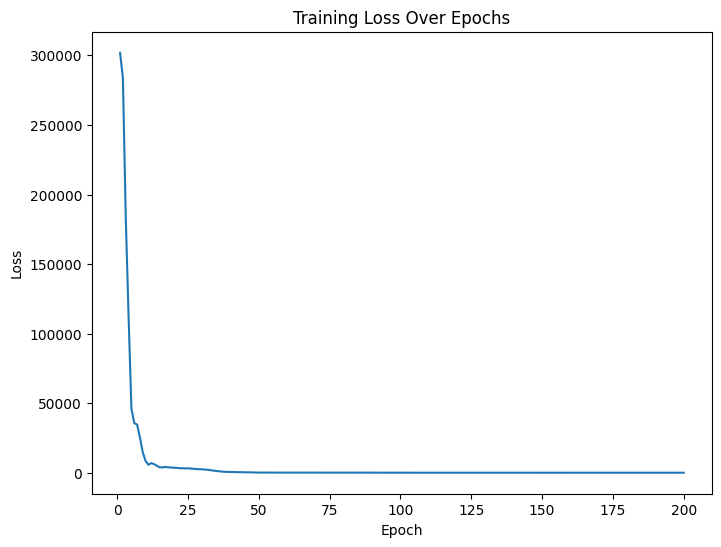

In [7]:
# Step 6: Evaluating the Model
print('\nStep 6: Evaluating the Model...')

# Set the model to evaluation mode
model.eval()  # Switch to evaluation mode (disables dropout and batch normalization if used)
with torch.no_grad():  # Disable gradient calculation for faster computation and reduced memory usage
    predictions = model(X_tensor).numpy()  # Generate predictions for the entire dataset
    # predictions[:, 0] = Predicted values for cycle_life
    # predictions[:, 1] = Predicted values for energy_density
    
    # Evaluate the predictions for cycle_life
    mae_cycle_life = mean_absolute_error(y[:, 0], predictions[:, 0])  # Calculate Mean Absolute Error (MAE) for cycle_life
    r2_cycle_life = r2_score(y[:, 0], predictions[:, 0])  # Calculate R² score for cycle_life (goodness of fit)
    
    # Evaluate the predictions for energy_density
    mae_energy_density = mean_absolute_error(y[:, 1], predictions[:, 1])  # Calculate MAE for energy_density
    r2_energy_density = r2_score(y[:, 1], predictions[:, 1])  # Calculate R² score for energy_density

    # Print the evaluation metrics
    print(f"Mean Absolute Error (MAE) for Cycle Life: {mae_cycle_life:.2f}, R²: {r2_cycle_life:.2f}")
    print(f"Mean Absolute Error (MAE) for Energy Density: {mae_energy_density:.2f}, R²: {r2_energy_density:.2f}")
    
    # Display predictions and true values for each sample
    print("\nPredictions vs True Values:")
    for i, (pred, true) in enumerate(zip(predictions, y)):
        print(f"Sample {i+1}: Predicted Cycle Life: {pred[0]:.2f}, True: {true[0]:.2f}; "
              f"Predicted Energy Density: {pred[1]:.2f}, True: {true[1]:.2f}")

# Plot the loss history to visualize training performance over epochs
plt.figure(figsize=(8, 6))  # Set the figure size
plt.plot(range(1, num_epochs + 1), loss_history)  # Plot the training loss
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.title('Training Loss Over Epochs')  # Title of the plot
plt.show()  # Display the plot



Step 7: Creating Heatmaps and Scatter Plots...
Creating Heatmap of Predicted Cycle Life vs Material and Temperature...


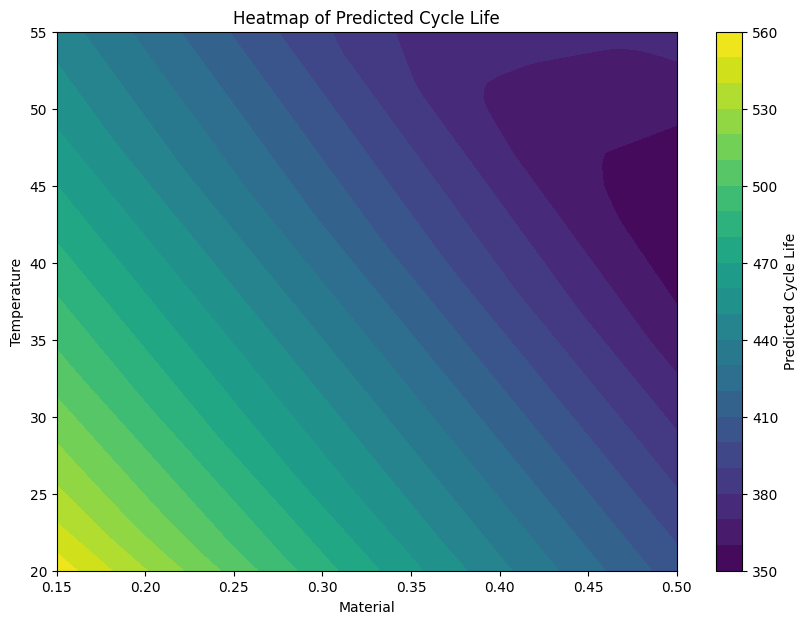

Creating Scatter Plots for each variable (Cycle Life)...


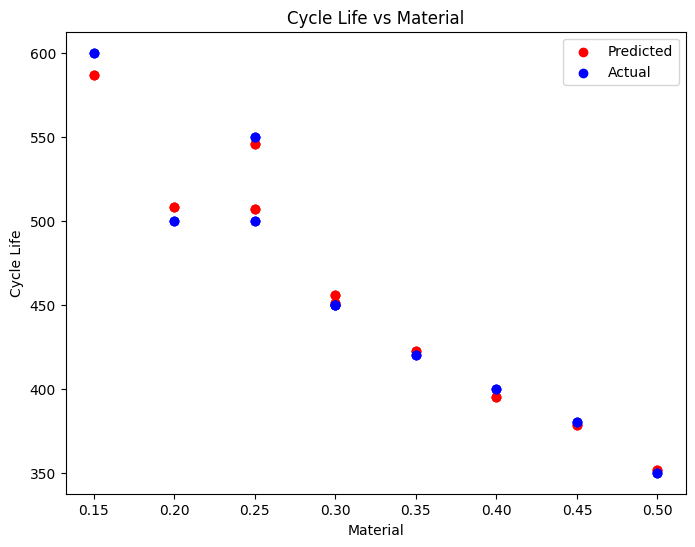

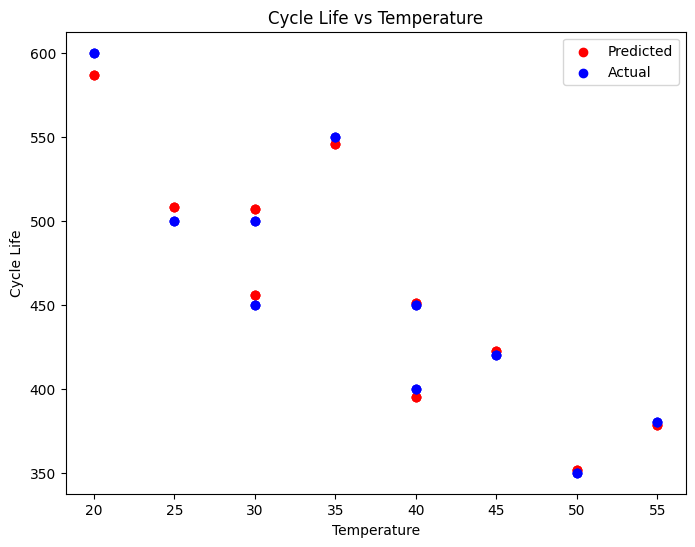

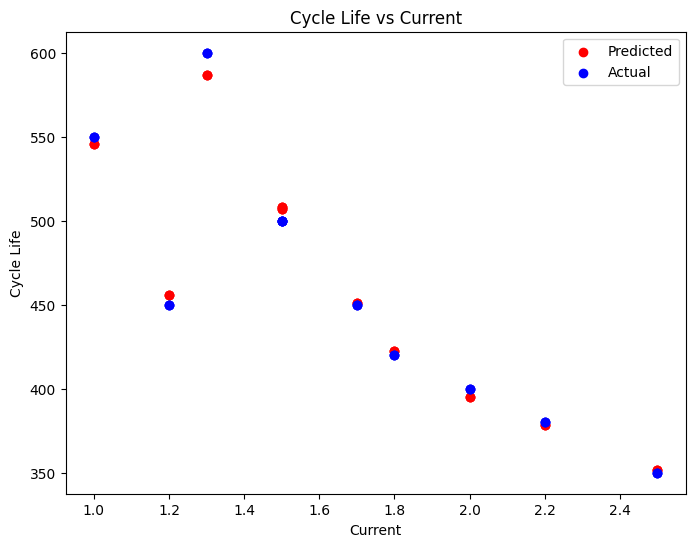

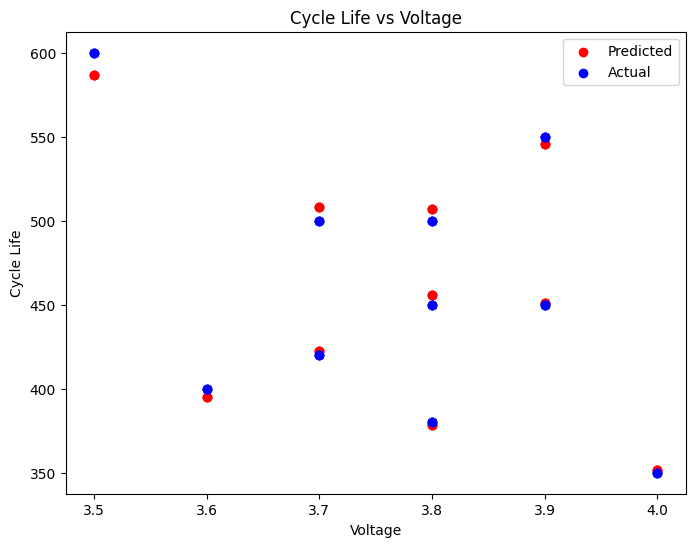

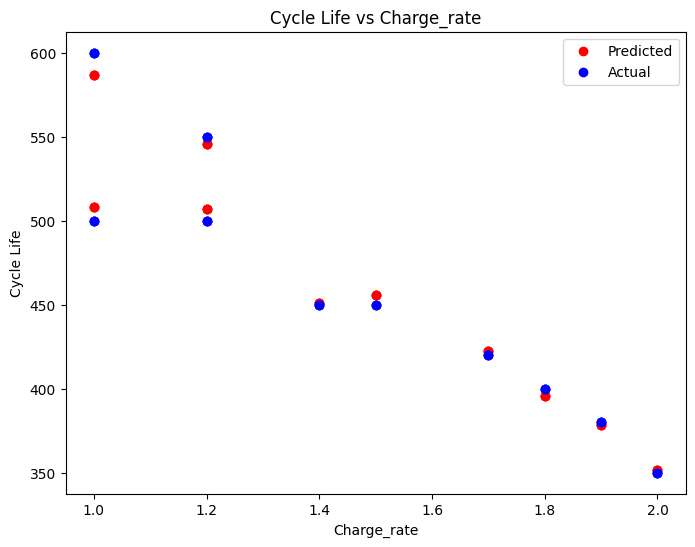

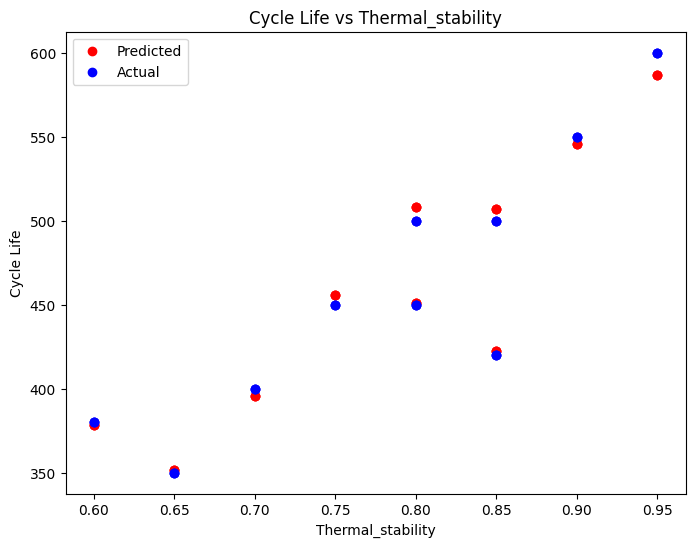

Creating Scatter Plots for each variable (Energy Density)...


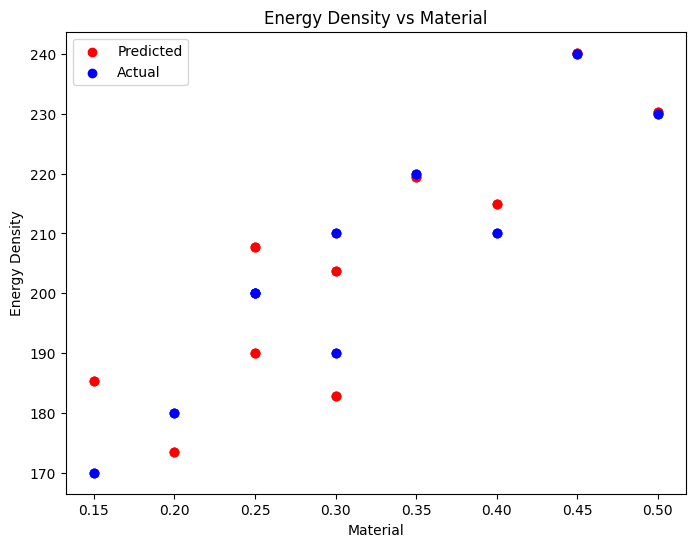

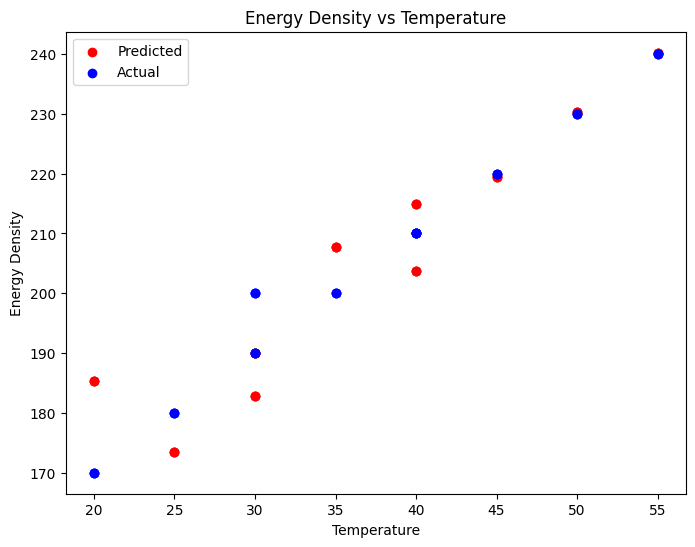

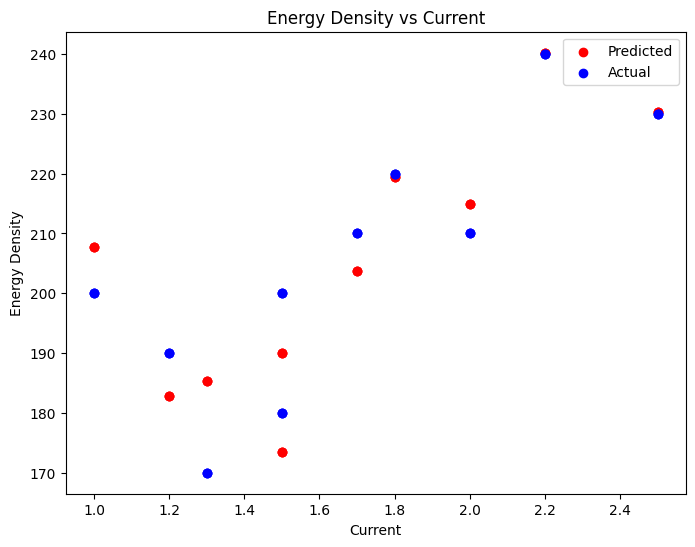

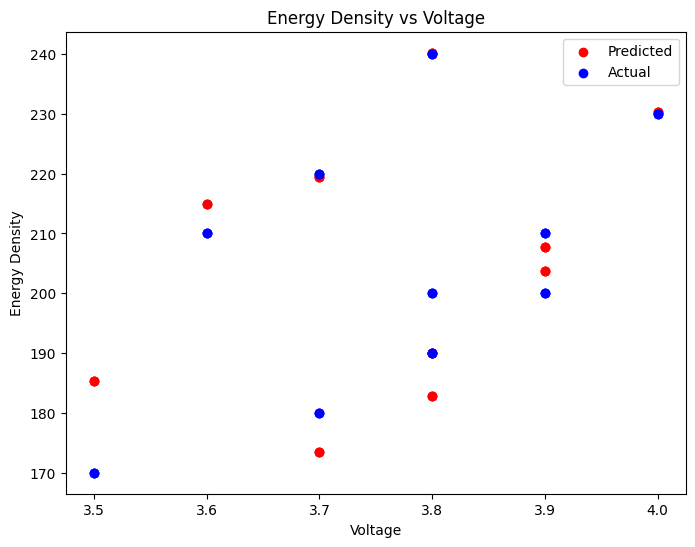

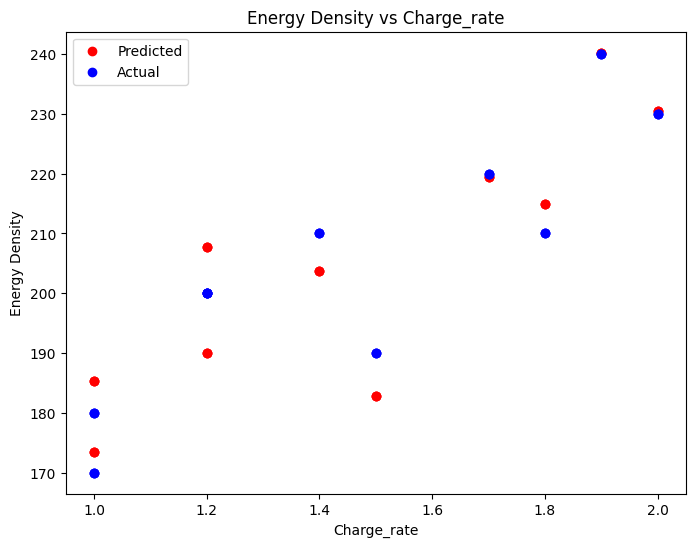

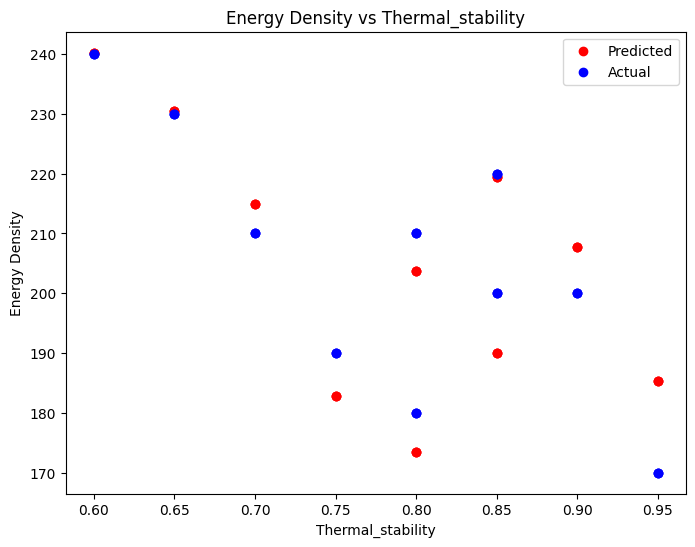


Creating Predicted vs Actual Plots for both targets...


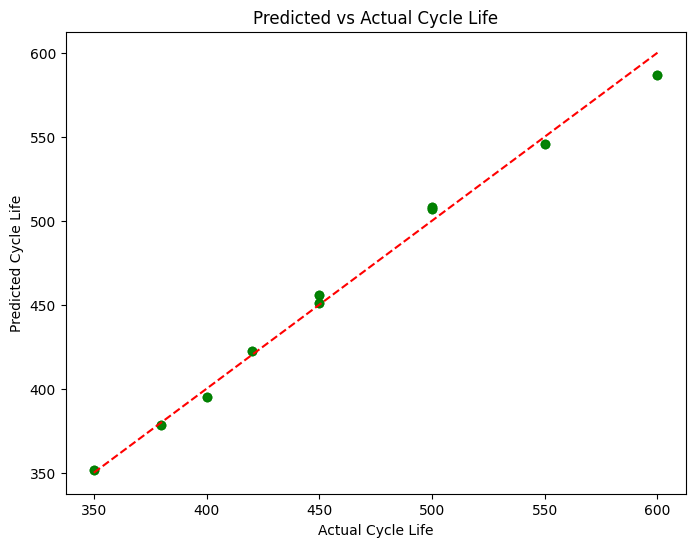

Residuals for Cycle Life:
[  8.25881958   5.57723999  -4.42071533  -4.63919067   2.32791138
 -13.19671631   1.4057312   -1.62649536   1.22229004   7.03677368
   8.25881958   5.57723999  -4.42071533  -4.63919067   2.32791138
 -13.19671631   1.4057312   -1.62649536   1.22229004   7.03677368
   8.25881958   5.57723999  -4.42071533  -4.63919067   2.32791138
 -13.19671631   1.4057312   -1.62649536   1.22229004   7.03677368]
Mean Absolute Error (MAE) for Cycle Life: 4.97
R² Score for Cycle Life: 0.99


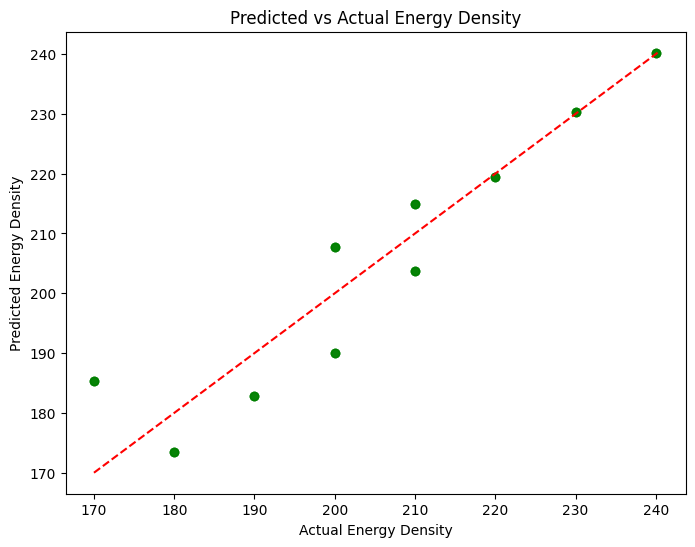

Residuals for Energy Density:
[-6.48979187 -7.16622925  7.75561523  4.98028564 -0.54072571 15.2774353
  0.39157104  0.22387695 -6.25939941 -9.93260193 -6.48979187 -7.16622925
  7.75561523  4.98028564 -0.54072571 15.2774353   0.39157104  0.22387695
 -6.25939941 -9.93260193 -6.48979187 -7.16622925  7.75561523  4.98028564
 -0.54072571 15.2774353   0.39157104  0.22387695 -6.25939941 -9.93260193]
Mean Absolute Error (MAE) for Energy Density: 5.90
R² Score for Energy Density: 0.87


In [8]:
# Step 7: Creating Heatmaps and Scatter Plots
print('\nStep 7: Creating Heatmaps and Scatter Plots...')

# Define variables for visualization (excluding targets as features)
variables = ['material', 'temperature', 'current', 'voltage', 'charge_rate', 'thermal_stability']  # CHANGED: Removed targets from variables
# Note: 'energy_density' has been removed from features since it's now a target variable.

# Create a DataFrame for easier plotting
plot_data = pd.DataFrame(X, columns=variables)  # Add feature data to the DataFrame
plot_data['Actual Cycle Life'] = y[:, 0]  # Add actual cycle life as a column
plot_data['Predicted Cycle Life'] = predictions[:, 0]  # Add predicted cycle life as a column
plot_data['Actual Energy Density'] = y[:, 1]  # Add actual energy density as a column
plot_data['Predicted Energy Density'] = predictions[:, 1]  # Add predicted energy density as a column

# Heatmap of Predicted Cycle Life vs Material and Temperature
print('Creating Heatmap of Predicted Cycle Life vs Material and Temperature...')
material_index = variables.index('material')  # Index of 'material' in features
temperature_index = variables.index('temperature')  # Index of 'temperature' in features

# Create grid ranges for material and temperature
material_range = np.linspace(X[:, material_index].min(), X[:, material_index].max(), 50)
temperature_range = np.linspace(X[:, temperature_index].min(), X[:, temperature_index].max(), 50)
material_grid, temperature_grid = np.meshgrid(material_range, temperature_range)  # Create a 2D grid

# Combine grid points into an array
grid_points = np.c_[material_grid.ravel(), temperature_grid.ravel()]

# Fix other variables at their mean values for the heatmap
other_vars = [v for v in variables if v not in ['material', 'temperature']]
fixed_values = X.mean(axis=0)[[variables.index(v) for v in other_vars]]  # Mean values for other variables

# Combine grid points with fixed values
X_grid = np.hstack((grid_points, np.tile(fixed_values, (grid_points.shape[0], 1))))
X_grid_scaled = scaler.transform(X_grid)  # Scale the grid points for model input
X_grid_tensor = torch.tensor(X_grid_scaled, dtype=torch.float32)  # Convert to PyTorch tensor

# Predict cycle_life for the grid points
model.eval()
with torch.no_grad():
    grid_predictions = model(X_grid_tensor).numpy()

# Reshape the predicted cycle_life to match the grid
cycle_life_grid = grid_predictions[:, 0].reshape(material_grid.shape)

# Plot the heatmap
plt.figure(figsize=(10, 7))
plt.contourf(material_grid, temperature_grid, cycle_life_grid, levels=20, cmap='viridis')  # Heatmap for cycle life
plt.colorbar(label='Predicted Cycle Life')  # Add color bar for scale
plt.xlabel('Material')  # Label for x-axis
plt.ylabel('Temperature')  # Label for y-axis
plt.title('Heatmap of Predicted Cycle Life')  # Title of the plot
plt.show()  # Display the heatmap

# Scatter Plots for each variable against Cycle Life
print('Creating Scatter Plots for each variable (Cycle Life)...')
for var in variables:  # Iterate over each feature
    plt.figure(figsize=(8, 6))
    plt.scatter(plot_data[var], plot_data['Predicted Cycle Life'], label='Predicted', color='red')  # Predicted values
    plt.scatter(plot_data[var], plot_data['Actual Cycle Life'], label='Actual', color='blue')  # Actual values
    plt.xlabel(var.capitalize())  # Capitalize feature name for label
    plt.ylabel('Cycle Life')  # Label for y-axis
    plt.title(f'Cycle Life vs {var.capitalize()}')  # Title of the plot
    plt.legend()  # Add legend
    plt.show()  # Display the scatter plot

# Scatter Plots for each variable against Energy Density
print('Creating Scatter Plots for each variable (Energy Density)...')
for var in variables:  # Iterate over each feature
    plt.figure(figsize=(8, 6))
    plt.scatter(plot_data[var], plot_data['Predicted Energy Density'], label='Predicted', color='red')  # Predicted values
    plt.scatter(plot_data[var], plot_data['Actual Energy Density'], label='Actual', color='blue')  # Actual values
    plt.xlabel(var.capitalize())  # Capitalize feature name for label
    plt.ylabel('Energy Density')  # Label for y-axis
    plt.title(f'Energy Density vs {var.capitalize()}')  # Title of the plot
    plt.legend()  # Add legend
    plt.show()  # Display the scatter plot

# Predicted vs Actual Plots for both Cycle Life and Energy Density
print('\nCreating Predicted vs Actual Plots for both targets...')
for target_name, actual_vals, pred_vals in [
    ("Cycle Life", y[:, 0], predictions[:, 0]),  # Compare cycle life
    ("Energy Density", y[:, 1], predictions[:, 1])  # Compare energy density
]:
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_vals, pred_vals, color='green', alpha=0.7)  # Scatter plot of actual vs predicted values
    min_val = min(actual_vals.min(), pred_vals.min())  # Minimum value for the 45-degree line
    max_val = max(actual_vals.max(), pred_vals.max())  # Maximum value for the 45-degree line
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Add a 45-degree line
    plt.xlabel(f'Actual {target_name}')  # Label for x-axis
    plt.ylabel(f'Predicted {target_name}')  # Label for y-axis
    plt.title(f'Predicted vs Actual {target_name}')  # Title of the plot
    plt.show()  # Display the scatter plot
    
    # Calculate residuals for analysis
    residuals = pred_vals - actual_vals
    print(f"Residuals for {target_name}:")
    print(residuals)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_vals, pred_vals)
    print(f"Mean Absolute Error (MAE) for {target_name}: {mae:.2f}")

    # Calculate R² Score
    r2 = r2_score(actual_vals, pred_vals)
    print(f"R² Score for {target_name}: {r2:.2f}")



Step 8: Suggesting Next Experiment using Multi-Objective Bayesian Optimization...



Suggested Next Experiment (Multi-Objective):
Material: 0.15000000, Temperature: 20.00000000, Current: 1.00000000, Voltage: 4.00000000, Charge Rate: 1.00000000, Thermal Stability: 0.95000000
Predicted Cycle Life: 753.08624268
Predicted Energy Density: 266.93399048
Visualizing the suggested experiment on the heatmap...


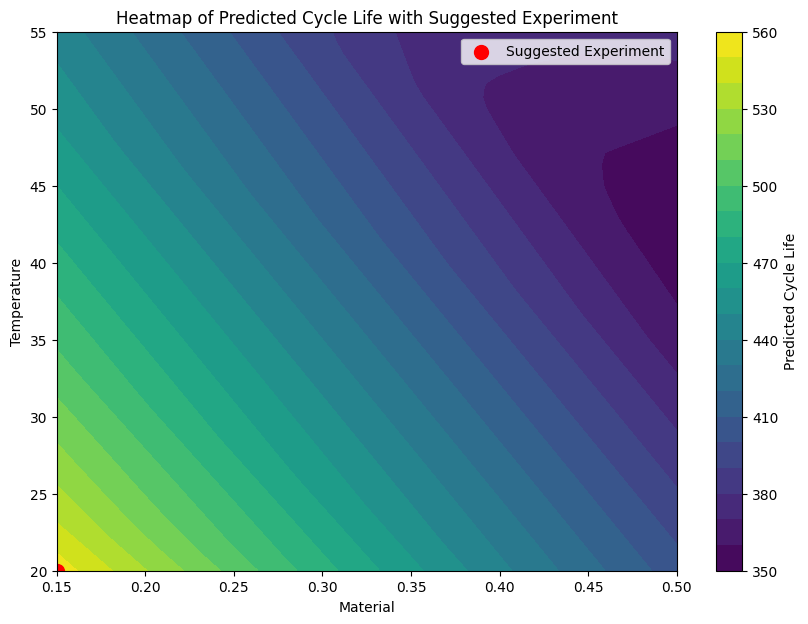

In [9]:
# Step 8: Suggesting Next Experiment using Multi-Objective Bayesian Optimization
print('\nStep 8: Suggesting Next Experiment using Multi-Objective Bayesian Optimization...')

def multi_objective_function(params):
    # Unpack parameters into individual variables
    material, temperature, current, voltage, charge_rate, thermal_stability = params

    # Combine input parameters into a single array
    X_input = np.array([[material, temperature, current, voltage, charge_rate, thermal_stability]])
    X_input_scaled = scaler.transform(X_input)  # Scale the input data
    X_input_tensor = torch.tensor(X_input_scaled, dtype=torch.float32)  # Convert to PyTorch tensor

    model.eval()  # Switch the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations for faster predictions
        pred = model(X_input_tensor).numpy()  # Get predictions: [cycle_life, energy_density]
    
    # Extract predictions for cycle_life and energy_density
    predicted_cycle_life = pred[0][0]
    predicted_energy_density = pred[0][1]

    # Define weights for the objectives
    weight_cycle_life = 0.6  # Assign 60% weight to cycle_life
    weight_energy_density = 0.4  # Assign 40% weight to energy_density
    
    # Combine objectives into a single score (negative for maximization)
    score = -(weight_cycle_life * predicted_cycle_life + weight_energy_density * predicted_energy_density)
    return score  # Return the combined score

bounds = [
    (0.15, 0.5),        # material
    (20.0, 55.0),       # temperature as float
    (1.0, 2.5),         # current
    (3.5, 4.0),         # voltage
    (1.0, 2.0),         # charge_rate
    (0.6, 0.95)         # thermal_stability
]


# Perform Bayesian optimization to find the best parameters
multi_result = gp_minimize(multi_objective_function, dimensions=bounds, n_calls=100, n_initial_points=10, random_state=42)

multi_best_params = multi_result.x  # Extract the best parameters from the optimization
multi_best_score = -multi_result.fun  # Convert score back to positive for interpretation

# Evaluate the best parameters to get predictions for both objectives
X_input = np.array([multi_best_params])  # Format the best parameters for model input
X_input_scaled = scaler.transform(X_input)  # Scale the input data
X_input_tensor = torch.tensor(X_input_scaled, dtype=torch.float32)  # Convert to PyTorch tensor

model.eval()  # Switch the model to evaluation mode
with torch.no_grad():  # Disable gradient calculations
    multi_best_pred = model(X_input_tensor).numpy()  # Get predictions: [cycle_life, energy_density]
multi_best_cycle_life = multi_best_pred[0][0]  # Predicted cycle_life for the best parameters
multi_best_energy_density = multi_best_pred[0][1]  # Predicted energy_density for the best parameters

# Display the suggested experiment with predictions
print('\nSuggested Next Experiment (Multi-Objective):')
print(f"Material: {multi_best_params[0]:.8f}, Temperature: {multi_best_params[1]:.8f}, "
      f"Current: {multi_best_params[2]:.8f}, Voltage: {multi_best_params[3]:.8f}, "
      f"Charge Rate: {multi_best_params[4]:.8f}, Thermal Stability: {multi_best_params[5]:.8f}")
print(f"Predicted Cycle Life: {multi_best_cycle_life:.8f}")
print(f"Predicted Energy Density: {multi_best_energy_density:.8f}")

# Visualize the suggested experiment on the heatmap
print('Visualizing the suggested experiment on the heatmap...')
plt.figure(figsize=(10, 7))
plt.contourf(material_grid, temperature_grid, cycle_life_grid, levels=20, cmap='viridis')  # Plot heatmap for cycle_life
plt.colorbar(label='Predicted Cycle Life')  # Add a color bar for reference
plt.scatter(multi_best_params[0], multi_best_params[1], color='red', label='Suggested Experiment', s=100)  # Highlight the suggested experiment
plt.xlabel('Material')  # Label for x-axis
plt.ylabel('Temperature')  # Label for y-axis
plt.title('Heatmap of Predicted Cycle Life with Suggested Experiment')  # Add a title to the plot
plt.legend()  # Add a legend to the plot
plt.show()  # Display the heatmap
